
# Rank Regression
[![Slides](https://img.shields.io/badge/🦌-ReHLine-blueviolet)](https://rehline-python.readthedocs.io/en/latest/)

Suppose we have a dataset $(y_i,\mathbf{x}_j)_{i=1}^n$, where $y_i \in \mathbb{R}$ is the response and $\mathbf{x}_i \in \mathbb{R}^{d}$ is the independent variable. Assume the data is generated from the following linear regression model,

$$
 y_i = \boldsymbol{\beta}^{\intercal}\mathbf{x}_i + \epsilon_i, \quad i=1,2,\cdots n,
$$
where $\boldsymbol{\beta} \in \mathbb{R}^d$ is the unknown parameter to be estimated and $\{\epsilon_i\}_{i=1}^n$ are iid random errors.  

When the random errors $\{\epsilon_i\}_{i=1}^n$ follow non-Gaussian distributions, particularly those with heavy tails, the performance of OLS maybe poor. Rank regression is one of the robust regression methods which can deal with the case. It suffices to solve the following optimization problem (Jaeckel, 1972):

$$
  \min_{\boldsymbol{\beta} \in \mathbb{R}^d} \sum\limits_{i=1}^{n}R_i^c(\boldsymbol{\beta})(y_i - \boldsymbol{\beta}^{\intercal}\mathbf{x}_i),
$$
where $R_i^c(\boldsymbol{\beta})=R_i(\boldsymbol{\beta}) - \frac{n+1}{2}$, $R_i(\boldsymbol{\beta})$ is the rank of ${y_i-\boldsymbol{\beta}^{\intercal}\mathbf{x}_i}$ among all $\{ y_i-\boldsymbol{\beta}^{\intercal}\mathbf{x}_i\}_{i=1}^n$. Canonically, we estimate $\boldsymbol{\beta}$ by solving the following optimization problem,

$$
  \min_{\boldsymbol{\beta} \in \mathbb{R}^d} \frac{2}{n(n-1)}\sum\limits_{1 \leq i < j \leq n} \big| y_{ij} - \boldsymbol{\beta}^{\intercal} \mathbf{x}_{ij} \big| \tag{1}
$$
where $\mathbf{x}_{ij} = \mathbf{x}_i - \mathbf{x}_j$, $y_{ij}= y_i - y_j$. In the remaining part, I will show two methods to solve $(1)$ with implementations via `rehline`.

In `ReHLine`, we have two options to solve rank regression: (i) use [Manual ReHLine Formulation](https://rehline-python.readthedocs.io/en/latest/tutorials/ReHLine_manual.html) based on `rehline.ReHLine`; (ii) use the form of [Empirical Risk Minimization](https://rehline-python.readthedocs.io/en/latest/tutorials/ReHLine_ERM.html) with the check loss based on `rehline.plqERM_Ridge`.
<!-- 
**Least absolute deviation (LAD)**  
By taking $\mathbf{x}_{ij}$ and $y_{ij}$ as observasions, problem $(1)$ can be regarded as a LAD problem. We can solve the LAD problem by rehline. The composite ReLU-ReHU parameters for LAD can be found in Table 2 of (Dai and Qiu, 2024).

**Quantile regression (QR)**  
Let $e_{ij}=y_{ij} - \boldsymbol{\beta}^{\intercal} \mathbf{x}_{ij}$. $(1)$ is equivalent to

$$
  \min_{\boldsymbol{\beta} \in \mathbb{R}^d} \frac{2}{n(n-1)} \sum\limits_{1 \leq i < j \leq n }  ( e_{ij} \mathbb{1}_{ \lbrace e_{ij} \geq 0 \rbrace} - e_{ij} \mathbb{1}_{ \lbrace e_{ij} < 0 \rbrace}   )  \tag{2}
$$

We compare $(2)$ with the check loss for quantile regression $\rho_{\tau}(ϵ)=ϵ(τ-\mathbb{1}_{\lbrace ϵ < 0 \rbrace}) = \tau ϵ \mathbb{1}_{ \lbrace \epsilon \geq 0 \rbrace } +(\tau-1)ϵ\mathbb{1}_{ \lbrace ϵ < 0 \rbrace}$. When $\tau=0.5$, solving $(2)$ is eqivalent to solving Quantile Regression by taking $\mathbf{x}_{ij}$ and $y_{ij}$ as observasions.

$$
  \min_{\boldsymbol{\beta} \in \mathbb{R}^d} \frac{4}{n(n-1)} \sum\limits_{1 \leq i < j \leq n }  \rho_{0.5}(y_{ij}-\boldsymbol{\beta}^{\intercal}\mathbf{x}_{ij})  \tag{3}
$$ -->

## Numerical example

### Preparation  
**Generate the data**

In [1]:
from rehline import ReHLine, plqERM_Ridge
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, QuantileRegressor
import numpy as np

np.random.seed(0)

# Generate the data
n, d = 3000, 3
X = np.random.randn(n, d)
beta_true = np.random.randn(d)
y = X.dot(beta_true) + np.random.standard_t(df=10, size=n)

**Pairwise differenced dataset**

In [2]:
# Differencing
i, j = np.triu_indices(n, k=1)
X_diff = (X[:, np.newaxis, :] - X[np.newaxis, :, :])[i,j]
y_diff = (y[:, np.newaxis] - y[np.newaxis, :])[i,j]
n_diff = y_diff.shape[0]

### Method 1: Solve Rank Regression via `rehline.plqERM_Ridge`

Since `rehline.plqERM_Ridge` support for check loss, we can directly use it to solve the problem.



In [3]:
# solve the problem use quantitle regression model with $\tau = 0.5$ by reline
C = 20/n_diff
RankReg = plqERM_Ridge(loss={'name': 'QR', 'qt': np.array([0.5])}, C=C, max_iter=10000)

In [4]:
%%time
RankReg.fit(X_diff, y_diff)

CPU times: user 793 ms, sys: 132 ms, total: 925 ms
Wall time: 925 ms


### Method 2: Solve Rank Regression by `rehline.ReHLine`
Since the rank regression is a plq formulation, we can also use `rehline.RehLine` to solve it by manually specifying the ReLU-ReHU parameters.

As shown in table 2 of (Dai and Qiu, 2024), when $L_i = C_i \big| y_i - \boldsymbol{\beta}^{\intercal} \mathbf{x}_i \big|$, ReLU parameters are as followed: $u_{1i}=C_i$, $v_{1i}=-C_i y_i$, $u_{2i}=-C_i$, $v_{2i}=C_i y_i$.

In [5]:
# solve the problem use the least absolute deviation model (LAD)
C = 20/n_diff/2
U = np.zeros(shape=(2,n_diff))
V = np.zeros(shape=(2,n_diff))
U[0,:], U[1,:] = C, -C
V[0,:], V[1,:] = -C * y_diff, C * y_diff
RankReg = ReHLine(C=C, max_iter=10000)
RankReg.U, RankReg.V = U,V

In [6]:
%%time
RankReg.fit(X_diff)

CPU times: user 737 ms, sys: 95 ms, total: 832 ms
Wall time: 830 ms


### Results

We compare the results of rank regression with OLS methods.

In [7]:
ols = LinearRegression(fit_intercept=False)
ols.fit(X, y)

LinearRegression(fit_intercept=False)

In [8]:
import pprint
np.set_printoptions(precision=4)

res = {'ture-β': beta_true, 'RankReg-β': RankReg.coef_, 'ols-β': ols.coef_}

## print the estimation results
print("Name".ljust(20), "Value".ljust(20))
print("-" * 20, "-" * 20)
print("#samples:".ljust(20), str(n).ljust(20))
print("#diff_samples:".ljust(20), str(n_diff).ljust(20))
print("-" * 20, "-" * 20)
for key, value in res.items():
    print(f"{str(key).ljust(20)} {str(value).ljust(20)}")

Name                 Value               
-------------------- --------------------
#samples:            3000                
#diff_samples:       4498500             
-------------------- --------------------
ture-β               [ 1.4171  0.4437 -0.077 ]
RankReg-β            [ 1.4207  0.4351 -0.0467]
ols-β                [ 1.4227  0.4386 -0.0364]


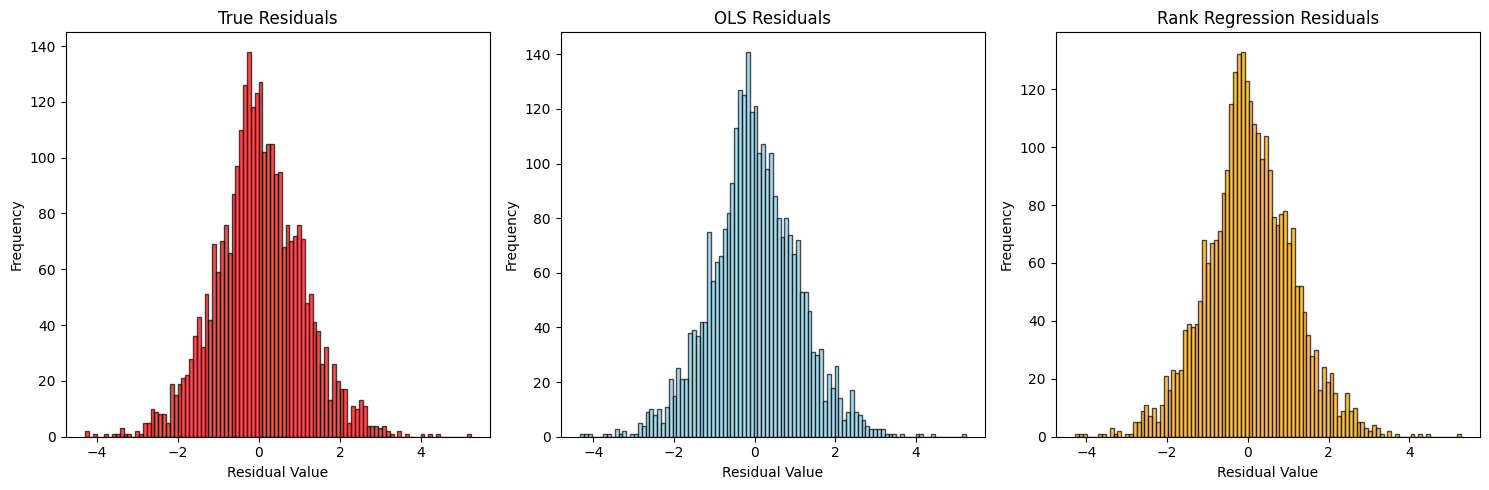

In [9]:
## plot residual results
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

res_true = y - X.dot(beta_true)
res_ols = y - ols.predict(X)
res_RR = y - np.mean(y) - X.dot(RankReg.coef_)

import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Histogram for true residuals
ax1.hist(res_true, bins=100, alpha=0.7, color='red', edgecolor='black')
ax1.set_title('True Residuals')
ax1.set_xlabel('Residual Value')
ax1.set_ylabel('Frequency')

# Histogram for OLS residuals
ax2.hist(res_ols, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_title('OLS Residuals')
ax2.set_xlabel('Residual Value')
ax2.set_ylabel('Frequency')

# Histogram for RR residuals
ax3.hist(res_RR, bins=100, alpha=0.7, color='orange', edgecolor='black')
ax3.set_title('Rank Regression Residuals')
ax3.set_xlabel('Residual Value')
ax3.set_ylabel('Frequency')

# Set layout and show plot
plt.tight_layout()
plt.show()

## References
[1] Jaeckel, L. A. (1972). Estimating regression coefficients by minimizing the dispersion of the residuals. _The Annals of Mathematical Statistics_, 1449-1458.  
[2]  Dai, B., & Qiu, Y. (2024). ReHLine: regularized composite ReLU-ReHU loss minimization with linear computation and linear convergence. _Advances in Neural Information Processing Systems_, 36.